# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau

  - Exemples de référence

  - Analyse des ensembles de niveau (Q1, Q2, Q3, Q4)

- Construction des courbes de niveau

  - Méthode de Newton (Q5, T1, T2)

  - Génération des points (Q6, T3)

  - Bouclage et auto-intersection (Q7, T4, T5)

- Post-traitement

  - Interpolation (Q8, T6)

  - Intégration (T7, T8)

## Préambule

### Dépendances logicielles 

In [235]:
# Python Standard Library
# -----------------------
pass

In [236]:
# Third-Party Libraries
# ---------------------

# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [237]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [238]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

#### Exemples d'usage

In [239]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([1., 2.])

In [240]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

#### Précautions

Les deux sources d'erreurs (avec messages cryptiques) les plus communes avec autograd :

**Selection de NumPy**

N'importez pas NumPy directement, par exemple avec

    >>> import numpy as np # Wrong !

mais importez le module `numpy` qui a été modifié par `autograd` (pour que les fonctions du module "coopérent" avec les algorithmes de différentiation automatique). 

    >>> import autograd.numpy as np # Right !
    
Utilisez-le ensuite comme vous le feriez avec NumPy classique.

**Utilisez des doubles**

Les fonctions générées par autograd sont strictes quand au type des nombres utilisés (plus strictes que les fonctions NumPy) : il doit s'agir de doubles. Par exemple, si l'on définit

    >>> def add(x, y):
    ...    return x + y
    >>> grad_add = grad(add)

Alors `grad_add(0.0, 0.0)` renvoie `array([1.0, 1.0])`, mais `grad_add(0, 0)` génère une erreur, car ses arguments sont des entiers et non des doubles.


## Ensembles de niveau

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}.
$$


### Exemples de référence

On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [241]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [242]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 

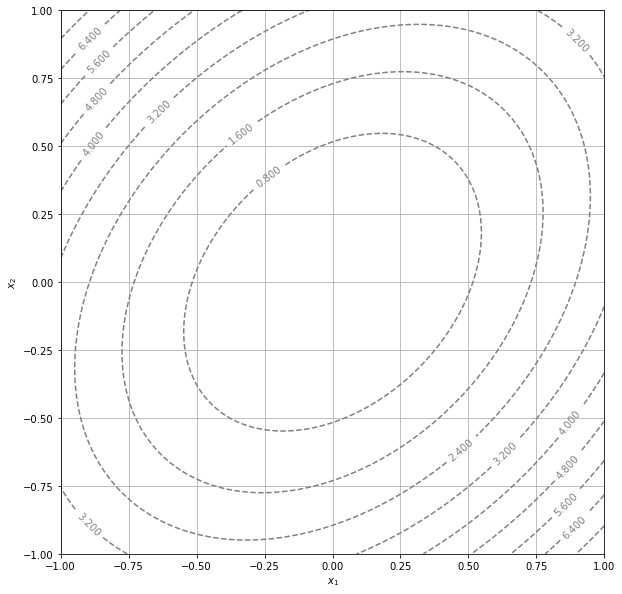

In [243]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x_1,x_2) \in \mathbb{R}^2 \mapsto (x_1 - 1)^2 + (x_1 - x_2^2)^2
$$

In [244]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

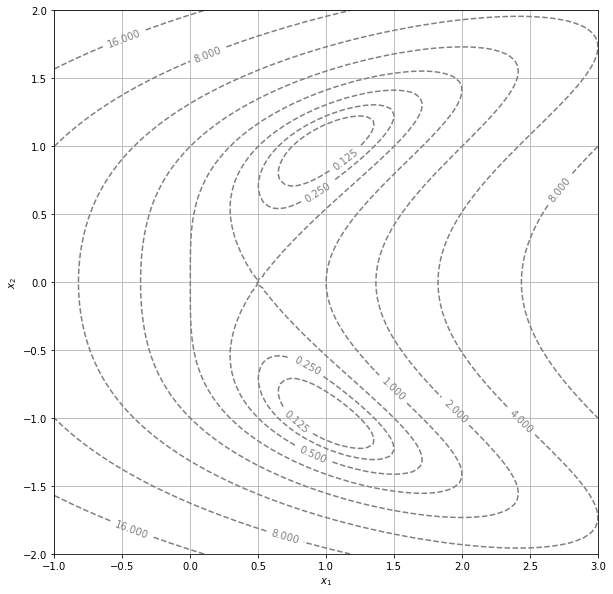

In [245]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [246]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

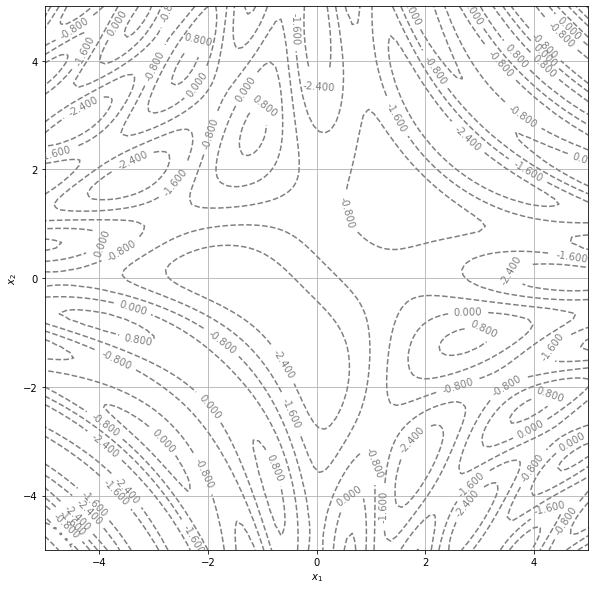

In [247]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

### Analyse des ensembles de niveau

#### Question 1

Soit $c \in \mathbb{R}$.
On suppose que la fonction $f:\mathbb{R}^2 \to \mathbb{R}$ est continue et vérifie
$f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$.
Que peut-on dire de l'ensemble de niveau $c$ de $f$ ?

#### Réponse 1
Soit $c \in \mathbb{R}$.


L'ensemble de niveau $c$ correspond à l'image réciproque par $f$ du singleton {$c$}. Or $f$ est une fonction continue et {$c$} est un fermé. Donc l'ensemble de niveau $c$ est fermé.

Par ailleurs, supposons cet ensemble non borné.   
Comme $f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$, il existe $A \in \mathbb{R}$ tel que pour tout $(x_1,x_2) \in \mathbb{R^2}$, si $\|(x_1,x_2)\| > A$, alors $f(x_1,x_2) > c$.  
Comme l'ensemble est non borné, il existe $(x_1,x_2)$ dans cet ensemble tel que $\|(x_1,x_2)\| > A$.   
Donc $f(x_1,x_2) > c$, donc $(x_1,x_2)$ n'appartient pas à l'ensemble, ce qui est absurde.  
Donc l'ensemble de niveau $c$ est borné.

L'ensemble de niveau $c$ est donc un compact.

Dans la suite la fonction $f$ est supposée continûment différentiable. On suppose également que le gradient $\nabla f$ ne s'annule pas dans un voisinage du point $x_0 = (x_{10}, x_{20}) \in \mathbb{R}^2$. On pose alors
$$
p(x_1, x_2) := \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} (x_1 - x_{10}) -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} (x_2 - x_{20}).
$$




#### Question 2
Comment interpréter géométriquement le terme $p(x_1,x_2)$ ?

#### Réponse 2
Posons $u = \frac{1}{\|\nabla f(x_0)\|}(\partial_2 f(x_0),-\partial_1 f(x_0))$.  
Le vecteur $u$ est unitaire et on constate que $(u \mid \nabla f(x_0)) = 0$.  
Sachant que $\nabla f(x_0)$ est un vecteur othogonal à la ligne de niveau en $x_0$, u est donc tangent à cette ligne en $x_0$.

On se rend donc compte que $p(x_1,x_2) = (u \mid (x_1-x_{10},x_2-x_{20}))$.  
Le terme p est donc la projection du vecteur $(x_1,x_2)$ sur $u$ avec pour origine $x_0$.

#### Question 3

Montrer que dans un voisinage ouvert de $x_0$, on peut paramétriser l'ensemble de niveau $c:=f(x_0)$ au moyen de $p(x_1,x_2),$ c'est-à-dire qu'il existe un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

#### Réponse 3
Posons $g : ((x_1,x_2),t) \in \mathbb{R^2} \times \mathbb{R^2} \mapsto (p(x_1,x_2)-t,f(x_1,x_2)-c)$.

La fonction $g$ est continuement différentiable car $t \mapsto t$, $(x_1,x_2) \mapsto p(x_1,x_2)$ et $f$ le sont.  
Par ailleurs $\partial_{(x_1,x_2)} g((x_1,x_2),t) = \begin{pmatrix} \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} & -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} \\ \partial_1 f(x_1,x_2) & \partial_2 f(x_1,x_2)) \end{pmatrix}$ est inversible.  

En effet le déterminant est égal à $\frac{(\partial_2 f(x_0))*\partial_2 f(x_1,x_2))}{\|\nabla f(x_0)\|} + \frac{(\partial_1 f(x_0))*\partial_1 f(x_1,x_2))}{\|\nabla f(x_0)\|}$ non nul pour (x_1,x_2) au voisinage de $x_0$.

On remarque qu'en posant $t_0 = 0$, $g(x_0,t_0) = 0$.  

D'après le théorème des fonction implicites, il existe donc un voisinage ouvert $U$ de $x_0$ et un voisinage $V$ de $t_0$ et une unique fonction implicite $\gamma : V \mapsto \mathbb{R^2}$ telle que :  
$ t = p(x_1, x_2) $ et $ f(x_1,x_2) = c \iff  (x_1, x_2) = \gamma(t)$

En particulier comme $V \in \mathbb{R}$ et que c'est un voisinage de $t_0 = 0$, il existe  $\varepsilon > 0$ tel que $\left]-\varepsilon;\varepsilon \right[ \in V$.  
On peut donc restreindre $\gamma$ à $\left]-\varepsilon;\varepsilon \right[$.

Donc on a en particulier :
$$f(x_1,x_2) = c \iff  (x_1, x_2) = \gamma(t)$$  
avec $t = p(x_1, x_2)$

#### Question 4

Montrer que pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ :

  - le vecteur $\gamma'(t)$ est non nul (il fournit donc une tangente au chemin $\gamma$),

  - est orthogonal à $\nabla f(\gamma(t))$.

### Réponse 4 ###

$\gamma'(t) = d\gamma(t) = -(\partial_{(x_1,x_2)} g((x_1,x_2),t))^{-1}.\partial_{t} g((x_1,x_2),t)$  
Or $-(\partial_{(x_1,x_2)} g((x_1,x_2),t))^{-1}$ est proportionnel à $\begin{pmatrix} \partial_2 f(x_1,x_2) &
\partial_1 f(x_0) \\ -\partial_1 f(x_1,x_2) & \partial_2 f(x_0) \end{pmatrix}$ et $\partial_{t} g((x_1,x_2),t) = \begin{pmatrix} -1 \\ 0 \end{pmatrix}$.  
Donc $\gamma'(t) =  \lambda*\begin{pmatrix} -\partial_2 f(x_1,x_2) \\ \partial_1 f(x_1,x_2) \end{pmatrix}$ avec $\lambda \in \mathbb{R*}$ donc $\gamma'(t)$ non nul car $(x_1,x_2)$ est au voisinage de $x_0$.  

Par ailleurs, $\nabla f(\gamma(t)) = \nabla f(x_1,x_2) = \begin{pmatrix} \partial_1 f(x_1,x_2) \\ \partial_2 f(x_1,x_2) \end{pmatrix}$  
D'où $\gamma'(t).\nabla f(x_1,x_2) = 0$.

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $x_0 \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

#### Question 5

L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [248]:
N = 10
eps = 1e-4 #L'epsilon machine est de l'ordre de 1e-16, toutefois une précision aussi importante n'est pas requise
           #pour visualiser les courbes de niveau.

#### Tâche 1

Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [249]:
def f1_n(niveau):
    """Renvoie la fonction associée à la courbe de niveau de hauteur 'niveau'.
    """
    def f1_p(x1,x2):
        return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 - niveau
    return f1_p

def f2_n(niveau):
    def f2_p(x1,x2):
        return (x1 - 1)**2 + (x1 - x2**2)**2 - niveau
    return f2_p

def f3_n(niveau):
    def f3_p(x,y):
        return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) - niveau
    return f3_p


def condition_x_egal_y(x,y):
    return x-y

def condition_x_egal_y_plus_un(x,y):
    return x-y-1

def condition_x_egal_deux_y(x,y):
    return x - 2*y


def display_contour(f, x, y, levels, L_points=[]):
    """Fonction permettant d'afficher un ensemble de courbes de niveau,
    ainsi que les points contenu dans la liste L_points.
    """
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    if L_points != [] :
        for i in L_points :
            plt.plot(i[0],i[1],'.')
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")
        
        
def Newton(F, condition, x0, y0, eps=eps, N=N):
    """Fonction renvoyant le couple (x,y,L) par la méthode de Newton
    tel que (F,condition)(x,y) = (0,0)
    et tel que L soit la liste des points (x,y) calculés.
    
    parameters
    ----------
    F : function
        fonction de R**2 dans R.
    condition : function
        fonction de R**2 dans R.
    x0,y0 : float
        coordonnées de départ de la recherche du zéro.
    eps : float
        précision de la méthode.
    N : int
        nombre maximal d'itération avant erreur.
    
    returns 
    -------
    x,y : float
        coordonnées (x,y) telles que (F,condtion)(x,y) = (0,0).
    L : list of np.ndarray
        liste des points calculés itérativement.
    """
    def f(x,y):
        return np.array([F(x,y),condition(x,y)])
    J_f = J(f)
    x,y = x0,y0
    L = [np.array([x0,y0])]
    for i in range(N):
        J_f_x = J_f(x,y)
        x,y = np.array([x,y]) - np.linalg.inv(J_f_x)@f(x,y)
        L.append(np.array([x,y]))
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x,y,L
        x0,y0 = x,y
    else:
        raise ValueError(f"no convergence in {N} steps.")

#### Tâche 2

Testez votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x_1, x_2)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x_1 = x_2$ en utilisant le point initial $(0.8, 0.8)$. Puis de faire varier le point initial, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

Le point tel que x1=x2 et f1(x1,x2) = 0.8 est : [0.4472136 0.4472136] 

Le point tel que x1=x2 et f2(x1,x2) = 0.25 est : [0.56460428 0.56460428]


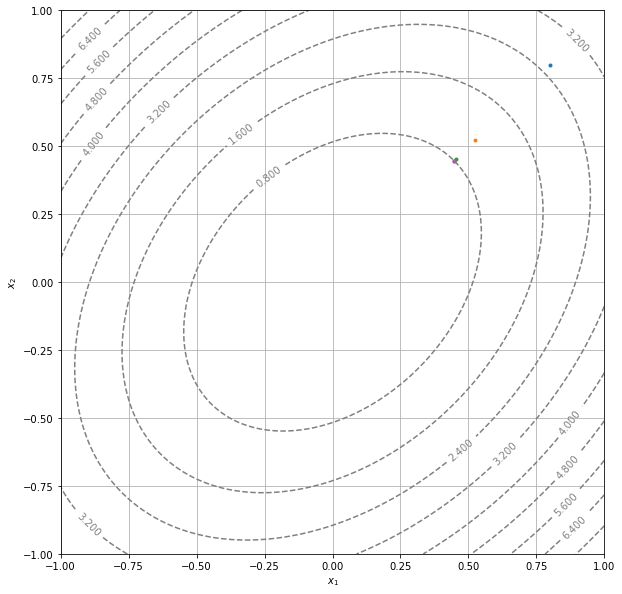

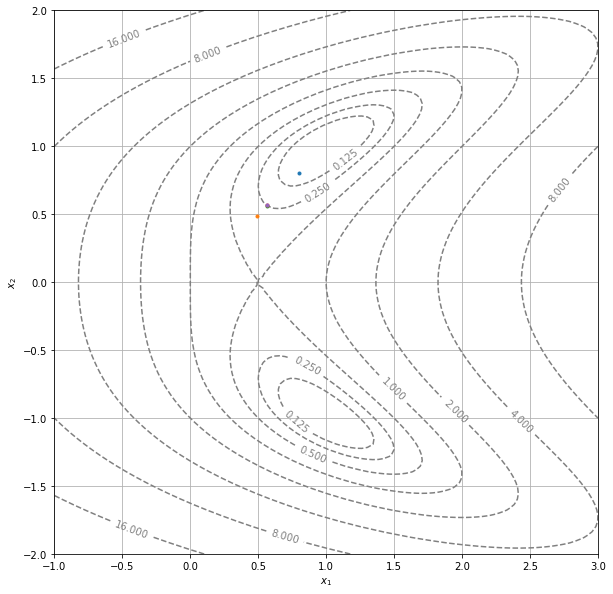

In [250]:
x,y,L = Newton(f1_n(0.8),condition_x_egal_y,0.8,0.8)
display_contour(f1, x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10,L_points = L)

print(f"Le point tel que x1=x2 et f1(x1,x2) = 0.8 est : {L[-1]} \n")

x,y,L = Newton(f2_n(0.25),condition_x_egal_y,0.8,0.8)
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)], 
    L_points = L)

print(f"Le point tel que x1=x2 et f2(x1,x2) = 0.25 est : {L[-1]}")

Le point tel que x1=x2+1 et f3(x1,x2) = -0.8 est : [1.5362775 0.5362775] 

Le point tel que x1=2x2 et f1(x1,x2) = 1.6 est : [-0.76277007 -0.38138504] 



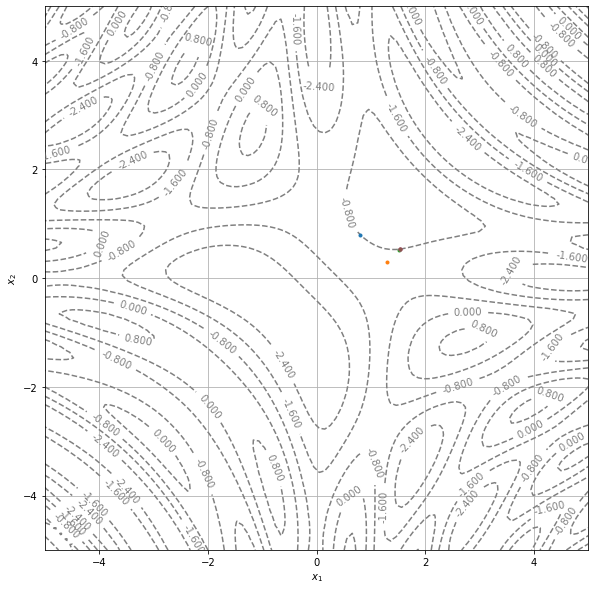

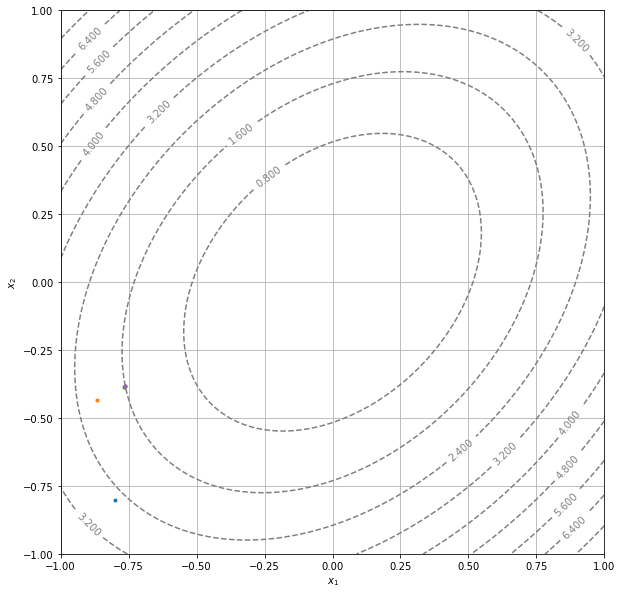

In [251]:
x,y,L = Newton(f3_n(-0.8),condition_x_egal_y_plus_un,0.8,0.8,N=100)
display_contour(f3, x=np.linspace(-5.0, 5.0, 100), y=np.linspace(-5.0, 5.0, 100), levels=5,L_points = L)
print(f"Le point tel que x1=x2+1 et f3(x1,x2) = -0.8 est : {L[-1]} \n")


x,y,L = Newton(f1_n(1.6),condition_x_egal_deux_y,-0.8,-0.8)
display_contour(f1, x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10,L_points = L)

print(f"Le point tel que x1=2x2 et f1(x1,x2) = 1.6 est : {L[-1]} \n")

### Génération des points

#### Question 6 + Tâche 3
Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille `(2, N)` contenant les coordonnées des points correspondants, puis valider graphiquement le résultat au moyen des exemples de référence.

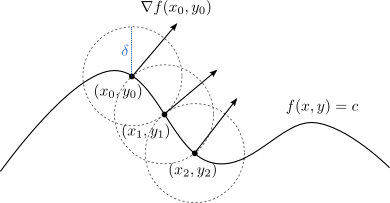

In [252]:
def level_curve(f, x_0, y_0, delta=0.1, N=10, eps=eps):
    """Fonction renvoyant la liste L des points se situant sur la courbe de niveau f.
    """
    L = []
    x,y = Newton(f,condition_x_egal_y,x_0,y_0)[:-1]
    for i in range(N):
        x0,y0 = x,y
        def condition_distance_delta(x,y):
            return (x-x0)**2 + (y-y0)**2-delta**2
        dx,dy = grad(f)(x0,y0)
        n = np.sqrt(dx**2+dy**2)
        u = np.array([dy/n,-dx/n])
        x,y = np.array([x0,y0])+delta*u
        x,y = Newton(f, condition_distance_delta, x, y, eps=eps, N=100)[:-1]
        L.append(np.array([x,y]))
    return L

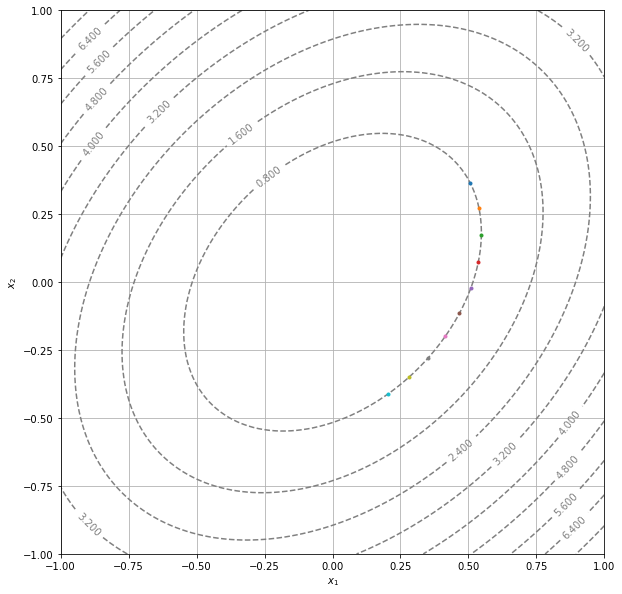

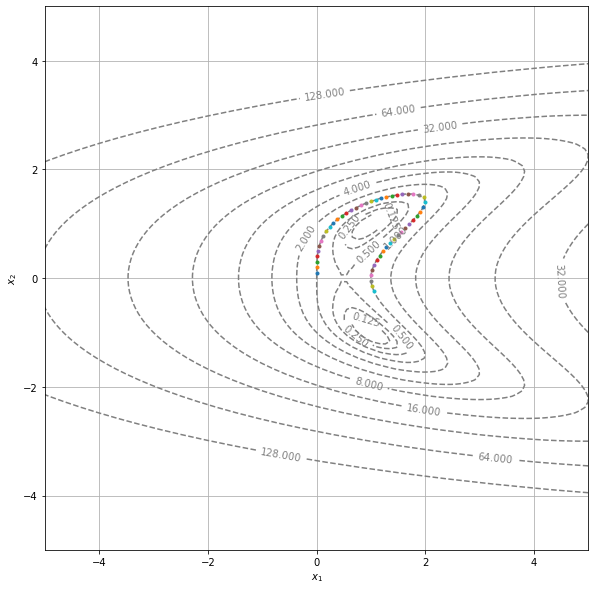

In [253]:
L = level_curve(f1_n(0.8),0.8,0.8)
display_contour(f1, x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10,
    L_points = L)


L = level_curve(f2_n(1.0),0.8,0.8,N=50)
display_contour(f2,
                x = np.linspace(-5.0,5.0,100),
                y = np.linspace(-5.0,5.0,100),
                levels=[2**i for i in range(-3, 8)],
                L_points = L)

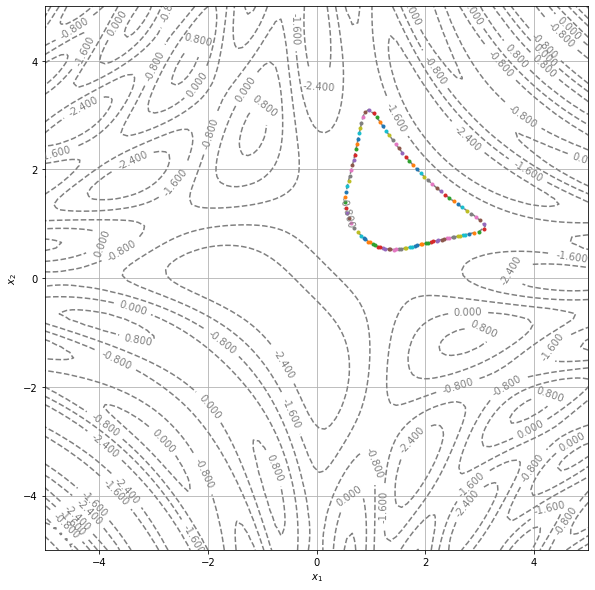

In [254]:
L = level_curve(f3_n(-0.8),0.8,0.8,N=100)
display_contour(f3, 
                x=np.linspace(-5.0, 5.0, 100), 
                y=np.linspace(-5.0, 5.0, 100), 
                levels=5,
                L_points = L)

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

#### Question 7 + Tâche 4

Proposer une nouvelle implémentation de `level_curve` qui arrête l'algorithme et renvoie les points connus quand le segment formé par les deux derniers points produits intersecte l'un des segments produits auparavant. En étant (raisonnablement) optimiste, doit-t'on prendre la peine de tester l'intersection du dernier segment avec tous les segments déjà produits (ce qui prend du temps ...) ou juste avec le premier ? Pour répondre à cette question, on pourra se demander si les courbes de niveau similaires à celle de la fonction de Rosenbrock passant par le point $(0.5, 0)$ (cf. Exemples de référence) -- c'est-à-dire "auto-intersectantes" -- sont fréquentes ou rares et pourquoi.

In [255]:
def longueur(x1,x2):
    return np.sqrt((x1[0]-x2[0])**2+(x1[1]-x2[1])**2)

def longueur_liste(L):
    liste = []
    for i,j in zip(L[:-1],L[1:]) :
        A = np.sqrt((i[0]-j[0])**2+(i[1]-j[1])**2)
        liste.append(A)
    return liste

def longueur_au_premier(L):
    if len(L) == 1:
        return 
    return longueur(L[-1],L[0])


def level_curve(f, x_0, y_0, delta=0.1, N=100, eps=eps):
    """Fonction renoyant L la liste des points se situant sur la courbe de niveau f.
    S'arrête si le tour de la courbe de niveau a été effectué.
    """
    x,y = Newton(f,condition_x_egal_y,x_0,y_0,eps=eps,N=1000)[:-1]
    L = [np.array([x,y])]
    tour = delta+1
    tour_complet = False
    for i in range(N):
        if tour>=delta  :
            x0,y0 = x,y
            def condition_distance_delta(x,y):
                return (x-x0)**2 + (y-y0)**2-delta**2
            dx,dy = grad(f)(x0,y0)
            n = np.sqrt(dx**2+dy**2)
            u = np.array([dy/n,-dx/n])
            x,y = np.array([x0,y0])+delta*u
            x,y = Newton(f, condition_distance_delta, x, y, eps=eps, N=1000)[:-1]
            L.append(np.array([x,y]))
            tour = longueur_au_premier(L)
        else :
            tour_complet = True
    if tour_complet :
        print("Tour complet effectué")
    return L



#### Tâche 5

Valider graphiquement le résultat au moyen des exemples de référence.


Tour complet effectué
Tour complet effectué


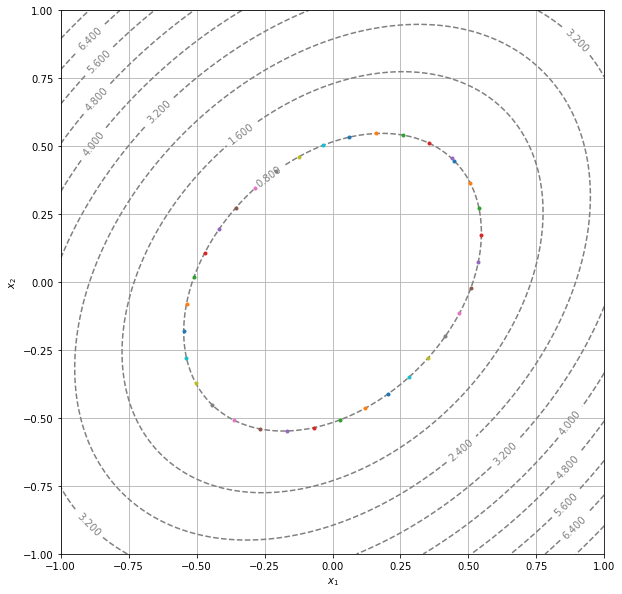

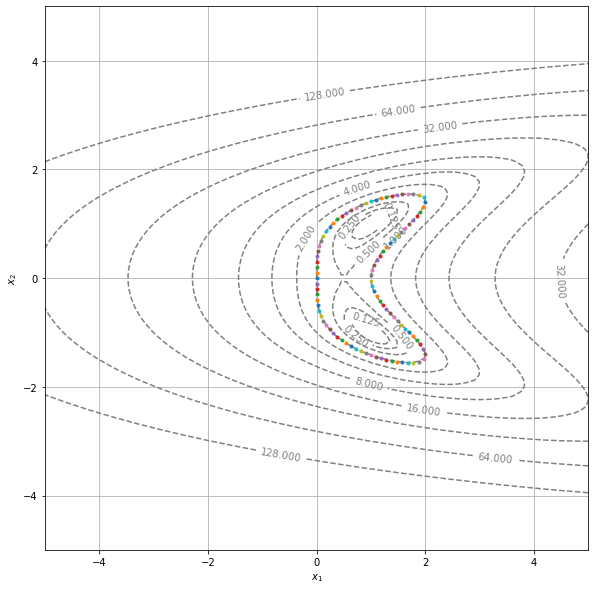

In [256]:
L = level_curve(f1_n(0.8),0.8,0.8)
display_contour(f1, x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10,
    L_points = L)


L = level_curve(f2_n(1.0),0.8,0.8,N=1000)
display_contour(f2,
                x = np.linspace(-5.0,5.0,100),
                y = np.linspace(-5.0,5.0,100),
                levels=[2**i for i in range(-3, 8)],
                L_points = L)



Tour complet effectué


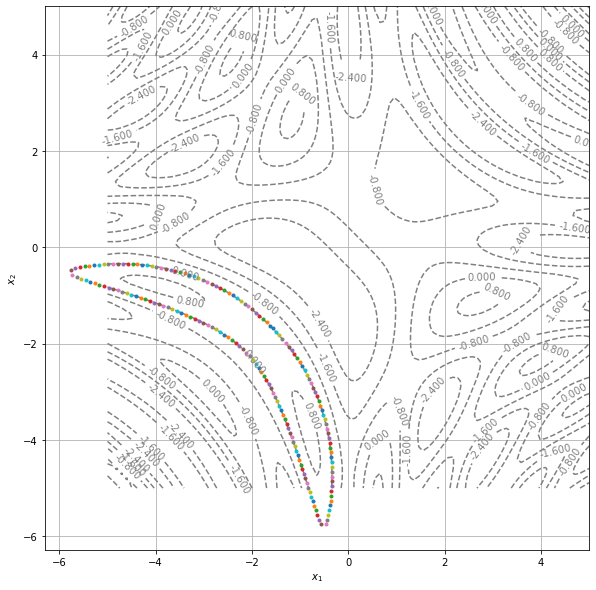

In [257]:
L = level_curve(f3_n(0),0.8,0.8,N=1000)
display_contour(f3, 
                x=np.linspace(-5.0, 5.0, 100), 
                y=np.linspace(-5.0, 5.0, 100), 
                levels=5,
                L_points = L)

## Post-traitement

Pour améliorer le rendu des courbes de niveau, il est tentant de diminuer la distance $\delta$ entre deux points consécutifs. Malheureusement, dans des cas d'usage réalistes, il est fréquent que la fonction $f$ soit beaucoup plus complexe que les exemples qui nous avons considérés. Le nombre de fois où cette fonction est appelée est alors le principal facteur qui détermine le temps de calcul des lignes de niveau. On cherche donc dans cette section à améliorer la qualité visuelle des résultats sans faire exploser le nombre d'évaluation de la fonction $f$. On va chercher à résoudre ce problème en reliant les points successifs par des chemins plus "flexibles" que des segments de droites, ayant le potentiel de mieux coller aux lignes de niveau.

### Interpolation 

#### Question 8

Soit $P_1$ et $P_2$ deux points du plan et $u_1$ et $u_2$ deux vecteurs du plan non nuls.
On cherche à produire un chemin $\gamma: [0,1] \to \mathbb{R}^2$ continûment différentiable, joignant $P_1$ et $P_2$ ($\gamma(0) = P_1$ et $\gamma(1) = P_2$), tel que $\gamma'(0)$ soit dans la même direction et le même sens que $u_1$ et $\gamma'(1)$ soit dans la même direction et le même sens que $u_2$.

On recherche une telle solution sous la forme
$\gamma(t) = (x(t), y(t))$ où 
$$
x(t) = a + bt + ct^2 \; \mbox{ et } \; y(t) = d + et + ft^2
$$
et les paramètres réels $a, b, c, d, e, f$ sont à déterminer(*).


Déterminer les coefficients $a, b, c, d, e, f$ solutions de ce problème quand ils existent.
Expliciter si nécessaire les conditions que doivent remplir $P_1$, $P_2$, $u_1$ et $u_2$ pour qu'une solution existe.

(*) Cf. ["Mathematical Typography" de Donald E. Knuth](https://projecteuclid.org/euclid.bams/1183544082) pp. 354-359 (Bull. Amer. Math. Soc. (N.S.), Volume 1, Number 2 (1979), 337-372), pour une classe de chemins interpolants similaire mais plus complexe.

#### Réponse 8
Notons $P_1 = (x_1,y_1)$ et $P_2 = (x_2,y_2)$.  
Notons $u_1 = (u_{x_1},u_{y_1})$ et $u_2 = (u_{x_2},u_{y_2})$.  
  
Déjà on a plusieurs équations :  
$x(0) = x_1$, $y(0) = y_1$, $x(1) = x_2$, $y(1) = y_2$  

On sait aussi que $\frac{d{\gamma}}{d{t}}$ est définie et continue pour toutes valeurs de $(a,b,c,d,e,f)$, avec $\frac{d{\gamma(t)}}{d{t}} = (b+2ct,e+2ft)$.  
On a alors $b = \lambda*u_{x_1}$, $e = \lambda*u_{y_1}$, $b + 2c = \mu*u_{x_2}$ et $e + 2f = \mu*u_{y_2}$, avec $\lambda > 0$ et $\mu > 0$. 

On a alors la solution $(a,b,c,d,e,f) = (x_1,\lambda*u_{x_1},x_2-x_1-\lambda*u_{x_1},y_1,\lambda*u_{y_1},y_2-y_1-\lambda*u_{y_1})$
Néanmoins on a deux contraintes supplémentaires pour l'existence de la solution car on a huit équations pour six inconnues :   
$2x_2-2x_1 = \lambda*u_{x_1} + \mu*u_{x_2}$  
$2y_2-2y_1 = \lambda*u_{y_1} + \mu*u_{y_2}$

On en déduit donc les conditions suivantes :  
$u_{x_1} \neq 0$  
$u_{y_2} + u_{x_2} \neq 0$  
$\lambda = 2\frac{x_2-x_1}{u_{x_1}}(1-\frac{1}{u_{y_2}+u_{x_2}}) - 2\frac{u_{x_1}(y_2-y_1)}{u_{y_2}+u_{x_2}}$  
$\mu = 2\frac{u_{x_1}(y_2-y_1)-x_2-x_1}{u_{y_2}+u_{x_2}}$  
Il faut donc vérifier que $\lambda > 0$ et $\mu > 0$.

#### Tâche 6

Implémenter la solution sous la forme d'une fonction `gamma` dont les arguments sont `t`, `P1`, `P2`, `u1` et `u2` et qui renvoie le ou les points $\gamma(t)$ associés. Lorsqu'il n'existe pas de chemin de la forme souhaitée pour les paramètres `P1`, `P2`, `u1` et `u2`, on utilisera comment remplacement de $\gamma$ un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

Pour des raisons de performance, on vectorisera cette fonction par rapport à `t` : 

  - en acceptant comme argument `t` des tableaux NumPy (monodimensionels) de nombres flottants et en renvoyant alors un tableau de taille `(2, len(t))` flottants décrivant l'abscisse et l'ordonnée des `len(t)` points $\gamma(t)$ correspondant,

  - en appliquant directement opérateurs et fonctions mathématiques aux tableaux NumPy, sans utiliser de boucle `for`,
  
On validera ensuite graphiquement l'implémentation sur un exemple où l'on représentera les point $P_1$ et $P_2$, les tangentes associées et le chemin $\gamma$ correspondant.




In [258]:
def gamma(t,P1,P2,u1,u2):
    """Fonction renvoyant une interpolation entre deux points.
    Cette interpolation est polynomiale si les deux points et leur vecteur tangent
    le permettent, ou linéaire dans le cas contraire.
    """
    #x1,x2,y1,y2,ux1,ux2,uy1,uy2 = P1[0],P2[0],P1[1],P2[1],u1[0],u2[0],u1[1],u2[1]
    #mu = ((2*x2-2*x1)*uy1-(2*y2-2*y1)*ux1)/(ux2*uy1-uy2*ux1)
    #lam = (2*x2-2*x1)/ux1-mu*ux2/ux1
    #print(lam,mu)
    #if lam > 0 and mu > 0 and ux2*uy1-uy2*ux1 != 0 and ux1 != 0:
    
    #if ((2*P2[0]-2*P1[0])/u1[0])*(1-1/(u2[1]+u2[0]))-(2*P2[1]-2*P1[1])/(u2[1]+u2[0])>0 and \
    #((2*P2[1]-2*P1[1])*u1[0]-2*P2[0]-2*P1[0])/(u2[1]+u2[0])>0:
    
    if 2*P2[0]-2*P1[0] == u1[0] + u2[0] and 2*P2[1]-2*P1[1] == u1[1] + u2[1]:
        a,b,c,d,e,f = P1[0],u1[0],P2[0]-P1[0]-u1[0],P1[1],u1[1],P2[1]-P1[1]-u1[1]
        T = np.zeros((2,len(t)))
        T[0] = a + b*t + c*t**2
        T[1] = d + e*t + f*t**2
        return T
    else :
        T = np.zeros((2,len(t)))
        T[0] = (1-t)*P1[0] + t*P2[0]
        T[1] = (1-t)*P1[1] + t*P2[1]
        return T

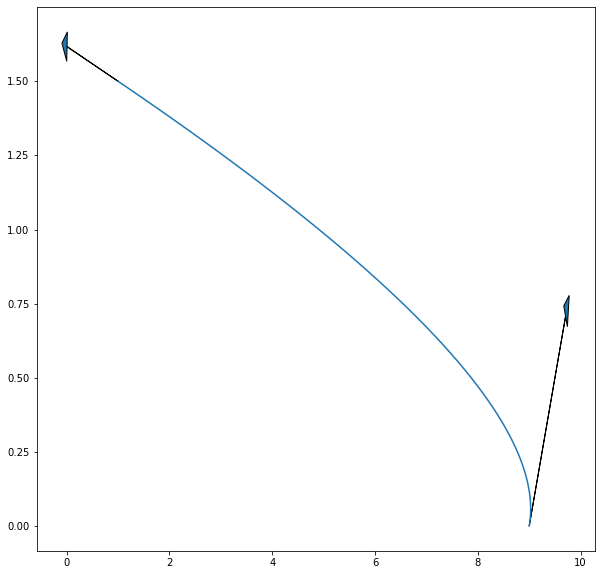

In [259]:
#Test pour un 4-uplet choisi au hazard
P1,P2,u1,u2 = np.array([9.0,0.0]),np.array([1.0,1.5]),np.array([1.0,1.0]),np.array([-17.0,2.0])
nb_points = 100

t_test = np.linspace(0,1,nb_points)

g_t = gamma(t_test,np.array([9.0,0.0]),np.array([1.0,1.5]),np.array([1.0,1.0]),np.array([-17.0,2.0]))
plt.plot(g_t[0],g_t[1])
plt.arrow(P1[0],P1[1],u1[0]/np.sqrt(u1[0]**2+u1[1]**2),u1[1]/np.sqrt(u1[0]**2+u1[1]**2),head_width=0.1, head_length=0.1)
plt.arrow(P2[0],P2[1],u2[0]/np.sqrt(u2[0]**2+u2[1]**2),u2[1]/np.sqrt(u2[0]**2+u2[1]**2),head_width=0.1, head_length=0.1)
plt.show()

### Intégration

#### Tâche 7
Intégrer le mécanisme d'interpolation dans (une nouvelle version de) la fonction `level_curve` qui accepte un nouveau paramètre entier `oversampling` (sur-échantillonnage) tel que :

  - si `oversampling == 1`, la fonction `level_curve` fonctionne comme précédemment,

  - si `oversampling > 1`, la fonction `level_curve` introduit dans son résultat `oversampling - 1` points supplémentaires obtenus par interpolations entre chaque couple de points consécutifs obtenus par la méthode de Newton.

In [260]:
def level_curve(f, x_0, y_0, delta=0.1, N=100, eps=eps, oversampling = 1):
    """Fonction renoyant L la liste des points se situant sur la courbe de niveau f.
    La variable oversampling>=1 permet d'ajouter oversampling-1 points interpolés 
    polynomialement ou linéairement entre chaque point calculé.
    """
    x,y = Newton(f,condition_x_egal_y,x_0,y_0,eps=eps,N=1000)[:-1]
    L = [np.array([x,y])]
    tour = delta+1
    tour_complet = False
    t = np.linspace(0,1,oversampling+1)
    for i in range(N):
        if tour>delta  :
            x0,y0 = x,y
            def condition_distance_delta(x,y):
                return (x-x0)**2 + (y-y0)**2-delta**2
            dx,dy = grad(f)(x0,y0)
            n = np.sqrt(dx**2+dy**2)
            u = np.array([dy/n,-dx/n])
            x,y = np.array([x0,y0])+delta*u
            x,y = Newton(f, condition_distance_delta, x, y, eps=eps, N=1000)[:-1]
            if oversampling > 1:
                dx0,dy0 = dx,dy
                dx1,dy1 = grad(f)(x,y)
                t_n = gamma(t,np.array([x0,y0]),np.array([x,y]),np.array([dx0,dy0]),np.array([dx1,dy1]))
                for j in zip(t_n[0,1:-1],t_n[1,1:-1]):
                    L.append(np.array([j[0],j[1]]))
            L.append(np.array([x,y]))
            tour = longueur_au_premier(L)
        else :
            tour_complet = True
    if tour_complet :
        print("Tour complet effectué")
    return L

def affiche_nuage_point(L):
    """Fonction affichant un nuage de point à partir d'une liste de 
    coordonnées np.ndarray([x,y]).
    """
    for i in L:
        plt.plot(i[0],i[1],'.')
    plt.show()
    return

#### Tâche 8

Valider graphiquement le résultat au moyen des exemples de référence.

Tour complet effectué


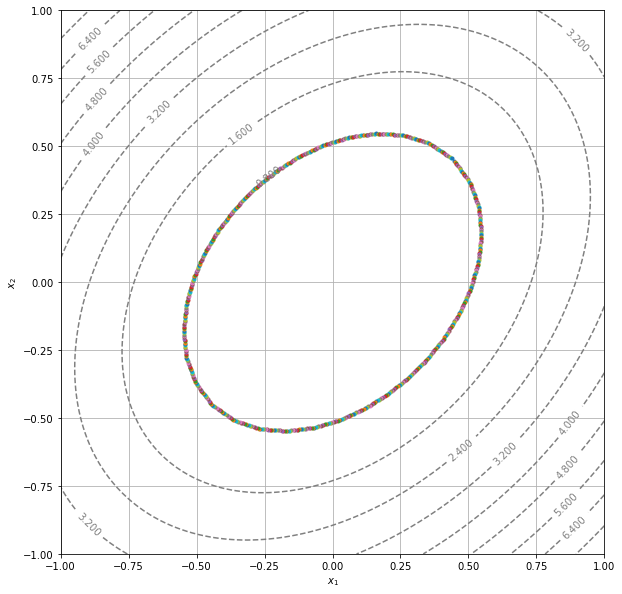

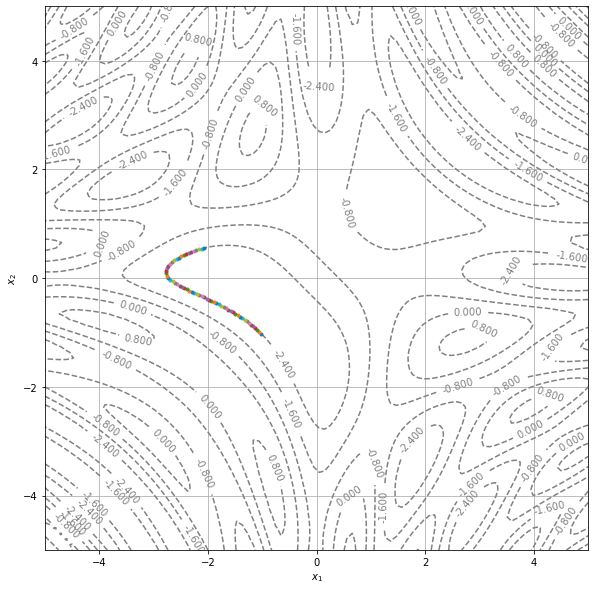

In [261]:
L = level_curve(f1_n(0.8),0.8,0.8,delta=0.1, N = 100,oversampling = 20)
display_contour(f1, x=np.linspace(-1.0, 1.0, 100), y=np.linspace(-1.0, 1.0, 100), levels=10,L_points = L)


L = level_curve(f3_n(-2.4),0.8,0.8,N=30,delta = 0.1,oversampling = 2)
display_contour(f3, x=np.linspace(-5.0, 5.0, 100), y=np.linspace(-5.0, 5.0, 100), levels=5,L_points = L)

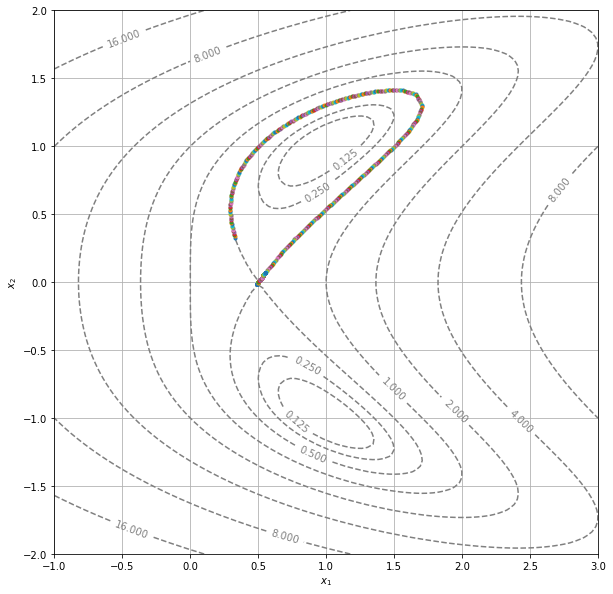

In [262]:
L = level_curve(f2_n(0.5), 0.8, 0.8, N=200, oversampling = 10)
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)], 
    L_points = L)

Tour complet effectué


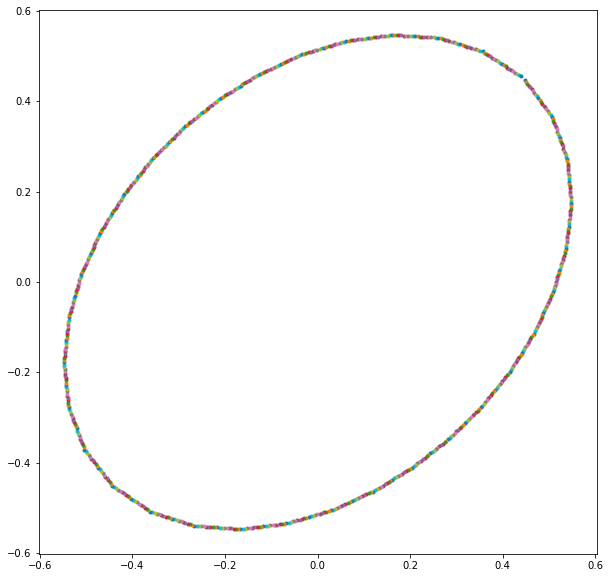

In [265]:
L = level_curve(f1_n(0.8),0.8,0.8,delta=0.1, N = 100,oversampling = 20)

affiche_nuage_point(L)

Tour complet effectué


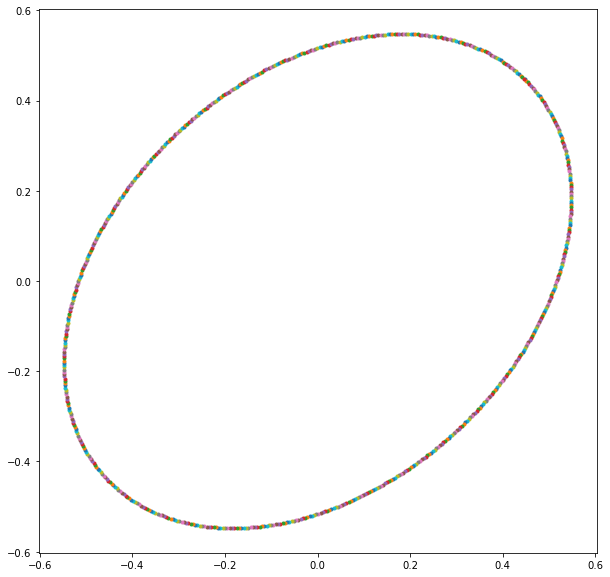

In [264]:
L = level_curve(f1_n(0.8),0.8,0.8,delta=0.005, N = 2000)

affiche_nuage_point(L)